In [1]:
import numpy as np
import pandas as pd
import requests
import datetime
import re
import time
from tkinter import *
import tkinter as tk
from tkinter import ttk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import seaborn as sns
import matplotlib.pyplot as plt
from pandastable import Table, TableModel
import matplotlib as mpl

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# 信用額度總量管制餘額表

In [69]:
res = requests.get('https://www.twse.com.tw/exchangeReport/TWT93U?response=csv&date=20201228')

In [70]:
a = res.text.split('\r\n')[1:-6] #原始文字清洗，清除首行及表尾說明語句

In [71]:
b = [a.replace('=', "") for a in a]  #非個股其證券代號名稱前會有等號，予以刪除
c = [c.split('","') for c in b] #每一列分割欄位

In [72]:
df = pd.DataFrame(c[2:], columns=c[1])
df = df.dropna()

In [73]:
df.columns = [i.strip('",') for i in df.columns]

In [74]:
df = df.applymap(lambda x:x.strip('",').replace(',',""))

In [75]:
df = df[df.股票代號!='合計']

In [76]:
df

,股票代號,股票名稱,前日餘額,賣出,買進,現券,今日餘額,限額,前日餘額,當日賣出,當日還券,當日調整,當日餘額,次一營業日可限額,備註
0,0050,元大台灣50,210000,0,0,0,210000,235750000,39519000,109000,2327000,0,37301000,1878041,
1,0051,元大中型100,0,0,0,0,0,2500000,10000,0,0,0,10000,15300,
2,0052,富邦科技,0,0,0,0,0,8375000,51000,0,0,0,51000,332846,
3,0053,元大電子,0,0,0,0,0,1372000,0,0,0,0,0,7911,
4,0054,元大台商50,0,0,0,0,0,1906000,0,0,0,0,0,4411,X
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1061,9945,潤泰新,552000,0,1000,0,551000,376220249,14198500,295000,0,0,14493500,1616376,
1062,9946,三發地產,14000,0,0,0,14000,75205216,1758000,2000,0,0,1760000,213617,
1063,9955,佳龍,2000,8000,0,0,10000,25802057,908000,0,0,0,908000,234729,
1064,9958,世紀鋼,536000,18000,103000,0,451000,57352310,5958049,182000,0,0,6140049,1480147,


# 證交所借券系統與證商/證金營業處所借券餘額合計表

In [77]:
res = requests.get('https://www.twse.com.tw/exchangeReport/TWT72U?response=csv&date=20201228&selectType=SLBNLB')

In [78]:
a = res.text.split('\r\n')[1:-6] #原始文字清洗，清除首行及表尾說明語句
b = [a.replace('=', "") for a in a]  #非個股其證券代號名稱前會有等號，予以刪除
c = [c.split('","') for c in b] #每一列分割欄位

In [79]:
df = pd.DataFrame(c[1:], columns=c[0])

In [80]:
df.columns = [i.strip('",') for i in df.columns]
df = df.applymap(lambda x:x.strip('",').replace(',',""))

In [81]:
df = df[df.證券代號!='合計']

In [82]:
df

,證券代號,證券名稱,前日借券餘額(1)股,本日異動股借券(2),本日異動股還券(3),本日借券餘額股(4)(1)+(2)-(3),本日收盤價(5)單位：元,借券餘額市值單位：元(6)(4)*(5),市場別
0,0050,元大台灣50,60419000,1381000,3898000,57902000,120.00,6948240000,集中市場
1,0051,元大中型100,10000,0,0,10000,43.83,438300,集中市場
2,0052,富邦科技,53000,0,0,53000,107.80,5713400,集中市場
3,0055,元大MSCI金融,61000,0,0,61000,17.71,1080310,集中市場
4,0056,元大高股息,982000,0,0,982000,29.75,29214500,集中市場
...,...,...,...,...,...,...,...,...,...
1425,9946,三發地產,2158000,2000,0,2160000,16.05,34668000,集中市場
1426,9951,皇田,309000,12000,0,321000,88.10,28280100,櫃檯買賣中心
1427,9955,佳龍,911000,0,0,911000,20.25,18447750,集中市場
1428,9958,世紀鋼,6287000,752000,477000,6562000,110.00,721820000,集中市場


In [2]:
request_times = 0
with open('Date_Setting.txt',mode='r') as f:
    settings = f.readlines()

settings = [i.replace('\n',"").split(":")[1] for i in settings]

START = settings[0]
END = settings[1]
BATCH = settings[2]
HISTORICAL_DATA = settings[3]


try:
    START = pd.to_datetime(START).date()
except:
    pass

try:
    END = pd.to_datetime(END).date()
except:
    pass

df = None
OMIT_DOWNLOAD = None

try:
    df = pd.read_csv("../{}".format(HISTORICAL_DATA))
    
except:
    OMIT_DOWNLOAD = None

if type(df) == pd.core.frame.DataFrame:
    OMIT_DOWNLOAD = True

In [3]:
if OMIT_DOWNLOAD == True:
    print('使用保存的歷史資料：{}'.format(HISTORICAL_DATA))


if (BATCH=='T' or BATCH=='TRUE' or BATCH=='True') & (OMIT_DOWNLOAD != True):

    if type(END) == pd._libs.tslibs.nattype.NaTType:
        END = datetime.date.today()
    else:
        pass
    
    print('啟動批次下載，期間為 : {}   至  {}'.format(START.strftime('%Y/%m/%d'), END.strftime('%Y/%m/%d')))

    date_range = []
    add_day = START
    Range_END = END+pd.tseries.offsets.MonthEnd(1)
    Range_END = Range_END.date()

    while add_day < Range_END:
        date_range.append(add_day)
        add_day = (add_day+pd.tseries.offsets.MonthEnd(1)).date()

    date_range.append(END)

    Data = pd.DataFrame()

    for i in range(len(date_range)-1):
        
        DATA_START = date_range[i]
        DATA_END = date_range[i+1]
        print(DATA_START,   DATA_END)
        
        try_count=1
        while try_count<10:
            try:
                print("第 {} 次嘗試下載".format(try_count))
                res = requests.get('https://www.twse.com.tw/SBL/t13sa710?response=csv&startDate={}&endDate={}&stockNo=&tradeType='.format(DATA_START.strftime('%Y%m%d'), DATA_END.strftime('%Y%m%d')))
                
                time.sleep(3)
                
                a = res.text.split('\r\n')[1:-6] #原始文字清洗，清除首行及表尾說明語句
                b = [a.replace('=', "") for a in a]  #非個股其證券代號名稱前會有等號，予以刪除
                c = [c.split('","') for c in b] #每一列分割欄位

                df = pd.DataFrame(c[1:], columns=c[0])

                df.columns = [col.replace('"', "").replace(",","") for col in df.columns]
                df = df.applymap(lambda x:str(x).replace('"', "").replace(",", ""))
                patterns = re.compile(u"[\u4e00-\u9fa5-A-z0-9&]+")

                pattern = r"^[0-9A-z]*"
                df['證券代號'] = df.證券代號名稱.apply(lambda x:re.findall(patterns,x)[0])
                df['證券名稱'] = df.證券代號名稱.apply(lambda x:re.findall(patterns,x)[1])

                df['成交日期'] = df.成交日期.apply(lambda x:int(re.sub(r'年|月|日', '', x))+19110000)
                df['成交日期'] = pd.to_datetime(df['成交日期'], format='%Y%m%d')
                df['成交日期'] = df['成交日期'].apply(lambda x:x.date())
                df['約定還券日期'] = df.約定還券日期.apply(lambda x:int(re.sub(r'年|月|日', '', x))+19110000)
                df['約定還券日期'] = pd.to_datetime(df['約定還券日期'], format='%Y%m%d')
                df['約定還券日期'] = df['約定還券日期'].apply(lambda x:x.date())

                df = df[['成交日期',
                '證券代號', 
                '證券名稱', 
                '交易方式', 
                '成交數量(交易單位)', 
                '成交費率', 
                '成交日收盤價', 
                '約定還券日期',
                '約定借券天數', 
                '費率異動'
               ]]

                df.成交費率 = df.成交費率.astype(float)
                df['成交數量(交易單位)'] = df['成交數量(交易單位)'].astype(int)
                
                print("下載成功")
                try_count=10
                Data = Data.append(df)

            except:
                print("下載失敗")
                try_count+=1
                
    print("全部資料下載完成")
    df = Data.drop_duplicates()
    print("儲存資料")
    df.to_csv("../最近一次批次抓取資料.csv", index=False, encoding="utf-8_sig")
    

while (request_times < 5) & (BATCH=="") & (OMIT_DOWNLOAD != True):
    try:
        print("抓取資料")
        
        today = datetime.date.today()

        if type(START) == pd._libs.tslibs.nattype.NaTType:
            print("無定義日期，預設使用上個月為開始時間")
            last_month_date = (today - pd.tseries.offsets.MonthEnd(1)).replace(day=1).date()

            res = requests.get('https://www.twse.com.tw/SBL/t13sa710?response=csv&startDate={}&endDate={}&stockNo=&tradeType='.format(last_month_date.strftime('%Y%m%d'), today.strftime('%Y%m%d')))

        elif (type(START) == datetime.date) & (type(END) == datetime.date):
            print("定義開始與結束日期為: {} 到 {}".format(START.strftime('%Y%m%d'), END.strftime('%Y%m%d')))

            res = requests.get('https://www.twse.com.tw/SBL/t13sa710?response=csv&startDate={}&endDate={}&stockNo=&tradeType='.format(START.strftime('%Y%m%d'), END.strftime('%Y%m%d')))

        else:
            print("定義開始日期為: {}".format(START.strftime('%Y%m%d')))

            res = requests.get('https://www.twse.com.tw/SBL/t13sa710?response=csv&startDate={}&endDate={}&stockNo=&tradeType='.format(START.strftime('%Y%m%d'), today.strftime('%Y%m%d')))

        
        #--------------清洗資料--------------
        a = res.text.split('\r\n')[1:-6] #原始文字清洗，清除首行及表尾說明語句
        b = [a.replace('=', "") for a in a]  #非個股其證券代號名稱前會有等號，予以刪除
        c = [c.split('","') for c in b] #每一列分割欄位
        
        df = pd.DataFrame(c[1:], columns=c[0])
        
        df.columns = [col.replace('"', "").replace(",","") for col in df.columns]
        df = df.applymap(lambda x:str(x).replace('"', "").replace(",", ""))
        patterns = re.compile(u"[\u4e00-\u9fa5-A-z0-9&]+")
        
        pattern = r"^[0-9A-z]*"
        df['證券代號'] = df.證券代號名稱.apply(lambda x:re.findall(patterns,x)[0])
        df['證券名稱'] = df.證券代號名稱.apply(lambda x:re.findall(patterns,x)[1])
        
        df['成交日期'] = df.成交日期.apply(lambda x:int(re.sub(r'年|月|日', '', x))+19110000)
        df['成交日期'] = pd.to_datetime(df['成交日期'], format='%Y%m%d')
        df['成交日期'] = df['成交日期'].apply(lambda x:x.date())
        df['約定還券日期'] = df.約定還券日期.apply(lambda x:int(re.sub(r'年|月|日', '', x))+19110000)
        df['約定還券日期'] = pd.to_datetime(df['約定還券日期'], format='%Y%m%d')
        df['約定還券日期'] = df['約定還券日期'].apply(lambda x:x.date())
        
        df = df[['成交日期',
        '證券代號', 
        '證券名稱', 
        '交易方式', 
        '成交數量(交易單位)', 
        '成交費率', 
        '成交日收盤價', 
        '約定還券日期',
        '約定借券天數', 
        '費率異動'
       ]]
        
        df.成交費率 = df.成交費率.astype(float)
        df['成交數量(交易單位)'] = df['成交數量(交易單位)'].astype(int)
        
        print("資料抓取成功")
        request_times = 5
        
    except:
        print("資料抓取失敗")
        time.sleep(3)
        request_times +=1


使用保存的歷史資料：20201106_134324.csv


In [4]:
with open('Core_Setting.txt',mode='r') as f:
    settings = f.readlines()

settings = [i.replace('\n',"").split(":")[1] for i in settings]

TABLE_WIDTH = float(settings[0])
TABLE_HEIGHT = float(settings[1])
PLOT_WIDTH = int(settings[2])
PLOT_HEIGHT = int(settings[3])

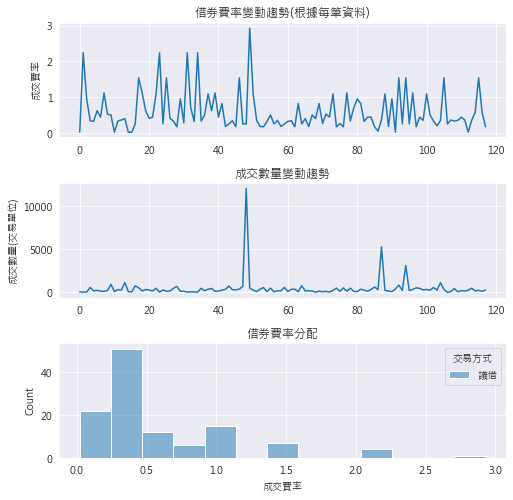

In [5]:
#Create the frame class and call my functions from inside the class
sns.set_style("darkgrid",{"font.sans-serif":['Microsoft JhengHei']})
mpl.rcParams['axes.unicode_minus'] = False


class UserInterface(Table):
    # Launch the df in a pandastable frame

    def handleCellEntry(self, row, col):
        super().handleCellEntry(row, col)
        print('changed:', row, col, "(TODO: update database)")
        return    

    def change_df_combo(self, event):
        #Responds to combobox, filter by 'Sec_type'
        global ui_df, refresh_plot
        combo_selection = str(combo_box.get())
        combo_selection1 = str(combo_box1.get())
        combo_selection2 = str(combo_box2.get())
        
        ui_df = pos_df.copy()
        
        if combo_selection == "選擇成交日期":
            pass
        else:
            ui_df = ui_df[pos_df.成交日期.apply(lambda x:str(x)) == combo_selection]
            
        if combo_selection1 == "選擇交易方式":
            pass
        else:
            ui_df = ui_df.query("交易方式 == @combo_selection1")
            
        if combo_selection2 == "選擇證券代號":
            pass
        else:
            ui_df = ui_df.query("證券代號 == @combo_selection2") 
        
        refresh_plot(event)
            
        self.updateModel(TableModel(ui_df))
        self.redraw()
        
    def change_df_combo1(self, event):
        #Responds to combobox, filter by 'Sec_type'
        global ui_df, refresh_plot
        combo_selection = str(combo_box.get())
        combo_selection1 = str(combo_box1.get())
        combo_selection2 = str(combo_box2.get())
        
        ui_df = pos_df.copy()
        
        if combo_selection == "選擇成交日期":
            pass
        else:
            ui_df = ui_df[pos_df.成交日期.apply(lambda x:str(x)) == combo_selection]
            
        if combo_selection1 == "選擇交易方式":
            pass
        else:
            ui_df = ui_df.query("交易方式 == @combo_selection1")
            
        if combo_selection2 == "選擇證券代號":
            pass
        else:
            ui_df = ui_df.query("證券代號 == @combo_selection2") 
            
        refresh_plot(event)
            
        self.updateModel(TableModel(ui_df))
        self.redraw()
        
    def change_df_combo2(self, event):
        global ui_df, refresh_plot
        #Responds to combobox, filter by 'Sec_type'
        combo_selection = str(combo_box.get())
        combo_selection1 = str(combo_box1.get())
        combo_selection2 = str(combo_box2.get())
        
        ui_df = pos_df.copy()
        
        if combo_selection == "選擇成交日期":
            pass
        else:
            ui_df = ui_df[pos_df.成交日期.apply(lambda x:str(x)) == combo_selection]
            
        if combo_selection1 == "選擇交易方式":
            pass
        else:
            ui_df = ui_df.query("交易方式 == @combo_selection1")
            
        if combo_selection2 == "選擇證券代號":
            pass
        else:
            ui_df = ui_df.query("證券代號 == @combo_selection2") 
            
        refresh_plot(event)

        self.updateModel(TableModel(ui_df))
        self.redraw()

        
def create_plot():
    # sns.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
#     sns.set_style("darkgrid",{"font.sans-serif":['Microsoft JhengHei']})
    # sns.set_style("darkgrid")
    
#     mpl.rcParams['axes.unicode_minus'] = False
    global PLOT_WIDTH, PLOT_HEIGHT

    fig, ax = plt.subplots(3,1,figsize=(PLOT_WIDTH, PLOT_HEIGHT))
    plt.subplots_adjust(hspace=0.4)

    sns.lineplot(y=ui_df.成交費率, x=list(range(len(ui_df.成交費率))), ax=ax[0])
    sns.lineplot(y=ui_df['成交數量(交易單位)'], x=list(range(len(ui_df.成交費率))), ax=ax[1])
    sns.histplot(x='成交費率', hue='交易方式', kde=False, stat='count', data=ui_df, ax=ax[2])

    ax[0].set_title('借券費率變動趨勢(根據每筆資料)')
    ax[1].set_title('成交數量變動趨勢')
    ax[2].set_title('借券費率分配')

    
    return fig

    
def refresh_plot(event):
    global fig, canvas, ui_df, PLOT_WIDTH, PLOT_HEIGHT
    
    # sns.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
#     sns.set_style("darkgrid",{"font.sans-serif":['Microsoft JhengHei']})
    # sns.set_style("darkgrid")
#     mpl.rcParams['axes.unicode_minus'] = False
    
    
    fig, ax = plt.subplots(3,1,figsize=(PLOT_WIDTH, PLOT_HEIGHT))
    plt.subplots_adjust(hspace=0.4)

    sns.lineplot(y=ui_df.成交費率, x=list(range(len(ui_df.成交費率))), ax=ax[0])
    sns.lineplot(y=ui_df['成交數量(交易單位)'], x=list(range(len(ui_df.成交費率))), ax=ax[1])
    sns.histplot(x='成交費率', hue='交易方式', kde=False, stat='count', data=ui_df, ax=ax[2])

    ax[0].set_title('借券費率變動趨勢(根據每筆資料)')
    ax[1].set_title('成交數量變動趨勢')
    ax[2].set_title('借券費率分配')
    
    
    canvas.figure = fig
#     canvas = FigureCanvasTkAgg(fig, master=root)
    canvas.draw()
#     canvas.get_tk_widget().grid(column=0, row=3, sticky=(NW),padx=5)

def manual_refresh_plot():
    global fig, canvas, ui_df, PLOT_WIDTH, PLOT_HEIGHT
    
    # sns.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
#     sns.set_style("darkgrid",{"font.sans-serif":['Microsoft JhengHei']})
    # sns.set_style("darkgrid")
#     mpl.rcParams['axes.unicode_minus'] = False
    
    
    fig, ax = plt.subplots(3,1,figsize=(PLOT_WIDTH, PLOT_HEIGHT))
    plt.subplots_adjust(hspace=0.4)

    sns.lineplot(y=ui_df.成交費率, x=list(range(len(ui_df.成交費率))), ax=ax[0])
    sns.lineplot(y=ui_df['成交數量(交易單位)'], x=list(range(len(ui_df.成交費率))), ax=ax[1])
    sns.histplot(x='成交費率', hue='交易方式', kde=False, stat='count', data=ui_df, ax=ax[2])

    ax[0].set_title('借券費率變動趨勢(根據每筆資料)')
    ax[1].set_title('成交數量變動趨勢')
    ax[2].set_title('借券費率分配')
    
    
    canvas.figure = fig
#     canvas = FigureCanvasTkAgg(fig, master=root)
    canvas.draw()
#     canvas.get_tk_widget().grid(column=0, row=3, sticky=(NW),padx=5)

def save_table():
    global  ui_df
    
    timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
    
    ui_df.to_csv("../{}.csv".format(timestamp), index=False, encoding="utf-8_sig")
    
    tk.messagebox.showinfo("儲存成功","檔名為 : {}.csv".format(timestamp))
    
    

    
pos_df = df
ui_df = pos_df

#Launch Tkinter basics
root = Tk()
root.title("借券費率")

mainframe = ttk.Frame(root, padding="3 3 3 3")
mainframe.grid(column=0, row=0, sticky=(N, W, E, S))
mainframe.columnconfigure(0, weight=1)
mainframe.rowconfigure(0, weight=1)
root.columnconfigure(0, weight=1)
root.rowconfigure(0, weight=1)

f = Frame(mainframe)
f.grid(column=0, columnspan=3,row=1, sticky=(E, W))
screen_width = f.winfo_screenwidth() * TABLE_WIDTH
screen_height = f.winfo_screenheight() * TABLE_HEIGHT

ui = UserInterface(f, dataframe=pos_df, height = screen_height, width = screen_width, showtoolbar=True, editable=False)


#Combobox to filter df
combo_choices = ['選擇成交日期']+list(np.unique(df.成交日期))
choice = StringVar()
combo_box = ttk.Combobox(mainframe, textvariable=choice)
combo_box['values'] = combo_choices
combo_box.grid(column=0, row=0, sticky=(NW))
combo_box.set("選擇成交日期")
combo_box.bind('<<ComboboxSelected>>', ui.change_df_combo)
combo_box.columnconfigure(0, weight=1)
combo_box.rowconfigure(0, weight=1)

#Combobox to filter df
combo_choices1 = ['選擇交易方式']+list(np.unique(df.交易方式))
choice1 = StringVar()
combo_box1 = ttk.Combobox(mainframe, textvariable=choice1, )
combo_box1['values'] = combo_choices1
combo_box1.grid(column=0, row=0, sticky=(N))
combo_box1.set("選擇交易方式")
combo_box1.bind('<<ComboboxSelected>>', ui.change_df_combo1)

combo_choices2 = ['選擇證券代號']+list(np.unique(df.證券代號))
choice2 = StringVar()
combo_box2 = ttk.Combobox(mainframe, textvariable=choice2)
combo_box2['values'] = combo_choices2
combo_box2.grid(column=0, row=0, sticky=(NE))
combo_box2.set("選擇證券代號")
combo_box2.bind('<<ComboboxSelected>>', ui.change_df_combo2)

refresh_button = tk.Button(mainframe, text='           ', command=manual_refresh_plot)
refresh_button.grid(column=1, row=0,  sticky=(N))

download_button = tk.Button(mainframe, text='儲存當前表格資料', command=save_table )
download_button.grid(column=2, row=0,  sticky=(NE))


fig = create_plot()
canvas = FigureCanvasTkAgg(fig, master=root)
canvas.draw()
canvas.get_tk_widget().grid(column=4, row=0, rowspan=3)

ui.show()

root.mainloop()

root.quit()

In [8]:
!pip install mplcursors --trusted-host pypi.python.org --trusted-host files.pythonhosted.org --trusted-host pypi.org

    ERROR: Command errored out with exit status 1:
     command: 'c:\users\user12\anaconda3\python.exe' -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\user12\\AppData\\Local\\Temp\\pip-install-yoybo6q7\\mplcursors\\setup.py'"'"'; __file__='"'"'C:\\Users\\user12\\AppData\\Local\\Temp\\pip-install-yoybo6q7\\mplcursors\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base 'C:\Users\user12\AppData\Local\Temp\pip-pip-egg-info-v6cggt1i'
         cwd: C:\Users\user12\AppData\Local\Temp\pip-install-yoybo6q7\mplcursors\
    Complete output (39 lines):
    ERROR: Could not find a version that satisfies the requirement setuptools_scm (from versions: none)
    ERROR: No matching distribution found for setuptools_scm
    Traceback (most recent call last):
      File "c:\users\user12\anaconda3\lib\site-packages\setuptools\installer.py", li

  Using cached mplcursors-0.4.tar.gz (86 kB)


In [28]:
TableModel()

Table Model with 20 rows

In [29]:
ui.redraw()

TclError: invalid command name ".!frame.!frame.!userinterface"

In [ ]:
ui.getSelectedDataFrame()

In [22]:
ui.showInfo()

TclError: can't invoke "toplevel" command: application has been destroyed

In [10]:
dir(ui)

['Xscrollbar',
 'Yscrollbar',
 '_Misc__winfo_getint',
 '_Misc__winfo_parseitem',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_bind',
 '_configure',
 '_create',
 '_displayof',
 '_do',
 '_eval',
 '_getFunction',
 '_getboolean',
 '_getconfigure',
 '_getconfigure1',
 '_getdoubles',
 '_getints',
 '_grid_configure',
 '_gridconvvalue',
 '_last_child_ids',
 '_name',
 '_nametowidget',
 '_noarg_',
 '_options',
 '_register',
 '_report_exception',
 '_root',
 '_setup',
 '_subst_format',
 '_subst_format_str',
 '_substitute',
 '_tclCommands',
 '_w',
 '_windowingsystem',
 'addColumn',
 'addRow',
 'addRows',
 'addtag',
 'addtag_above',
 'addtag_all'

In [7]:
dir(ui)

['Xscrollbar',
 'Yscrollbar',
 '_Misc__winfo_getint',
 '_Misc__winfo_parseitem',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_bind',
 '_configure',
 '_create',
 '_displayof',
 '_do',
 '_eval',
 '_getFunction',
 '_getboolean',
 '_getconfigure',
 '_getconfigure1',
 '_getdoubles',
 '_getints',
 '_grid_configure',
 '_gridconvvalue',
 '_last_child_ids',
 '_name',
 '_nametowidget',
 '_noarg_',
 '_options',
 '_register',
 '_report_exception',
 '_root',
 '_setup',
 '_subst_format',
 '_subst_format_str',
 '_substitute',
 '_tclCommands',
 '_w',
 '_windowingsystem',
 'addColumn',
 'addRow',
 'addRows',
 'addtag',
 'addtag_above',
 'addtag_all'

Text(0.5, 1.0, '借券費率分配')

C:\Users\user12\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\user12\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


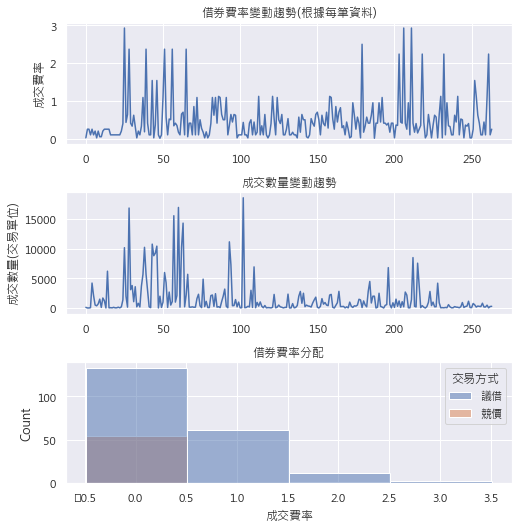

In [26]:
# sns.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
sns.set_style("darkgrid",{"font.sans-serif":['Microsoft JhengHei']})
# sns.set_style("darkgrid")

fig, ax = plt.subplots(3,1,figsize=(8, 8))
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.4)


sns.lineplot(y=ui_df.成交費率, x=list(range(len(ui_df.成交費率))), ax=ax[0])
sns.lineplot(y=ui_df['成交數量(交易單位)'], x=list(range(len(ui_df.成交費率))), ax=ax[1])
sns.histplot(x='成交費率', hue='交易方式', kde=False, discrete=True, stat='count', data=ui_df, ax=ax[2])

ax[0].set_title('借券費率變動趨勢(根據每筆資料)')
ax[1].set_title('成交數量變動趨勢')
ax[2].set_title('借券費率分配')

In [34]:
ui_df['成交數量(交易單位)'] = ui_df['成交數量(交易單位)'].astype(float)

In [37]:
ui_df.groupby('成交日期').mean().reset_index()

,成交日期,成交數量(交易單位),成交費率
0,2020-09-15,649.914498,2.544052
1,2020-09-16,911.346988,1.869735
2,2020-09-17,845.091503,1.850752
3,2020-09-18,587.678571,2.173466
4,2020-09-21,1284.008746,1.635627
5,2020-09-22,289.370044,1.574471
6,2020-09-23,679.873315,1.304178
7,2020-09-24,494.945652,1.540054
8,2020-09-25,298.901216,1.433070
9,2020-09-28,529.016393,2.376230


In [13]:
ui_df

,成交日期,證券代號,證券名稱,交易方式,成交數量(交易單位),成交費率,成交日收盤價,約定還券日期,約定借券天數,費率異動
0,2020-09-15,0061,元大寶滬深,議借,800,1.50,21.35,2021-03-12,178,
1,2020-09-15,00633L,富邦上証正2,競價,15,2.00,57.00,2021-03-15,181,
2,2020-09-15,00637L,元大滬深300正2,競價,100,1.50,22.18,2021-03-15,181,
3,2020-09-15,00677U,富邦VIX,競價,800,2.80,4.77,2021-03-15,181,
4,2020-09-15,1102,亞泥,議借,400,0.25,42.70,2021-03-15,181,
...,...,...,...,...,...,...,...,...,...,...
7142,2020-10-16,9914,美利達,議借,113,2.55,239.00,2021-04-16,182,
7143,2020-10-16,9919,康那香,競價,3,2.50,41.10,2021-04-16,182,
7144,2020-10-16,9921,巨大,議借,27,0.20,262.00,2021-04-16,182,
7145,2020-10-16,9933,中鼎,議借,800,2.00,38.80,2021-04-16,182,


In [17]:
np.unique(ui_df.成交費率)

array([1.000e-02, 2.000e-02, 3.000e-02, 5.000e-02, 1.000e-01, 1.500e-01,
       1.700e-01, 1.800e-01, 2.000e-01, 2.500e-01, 2.700e-01, 2.800e-01,
       2.900e-01, 3.000e-01, 3.200e-01, 3.300e-01, 3.400e-01, 3.500e-01,
       3.600e-01, 4.000e-01, 4.100e-01, 4.300e-01, 4.400e-01, 4.500e-01,
       5.000e-01, 5.200e-01, 5.300e-01, 5.500e-01, 5.700e-01, 6.000e-01,
       6.200e-01, 6.400e-01, 6.500e-01, 7.000e-01, 7.500e-01, 8.000e-01,
       8.200e-01, 8.500e-01, 9.000e-01, 9.500e-01, 1.000e+00, 1.050e+00,
       1.090e+00, 1.100e+00, 1.120e+00, 1.150e+00, 1.200e+00, 1.250e+00,
       1.300e+00, 1.330e+00, 1.350e+00, 1.400e+00, 1.450e+00, 1.500e+00,
       1.520e+00, 1.540e+00, 1.550e+00, 1.600e+00, 1.650e+00, 1.700e+00,
       1.750e+00, 1.800e+00, 1.850e+00, 1.890e+00, 1.900e+00, 1.950e+00,
       2.000e+00, 2.050e+00, 2.100e+00, 2.150e+00, 2.200e+00, 2.210e+00,
       2.240e+00, 2.250e+00, 2.280e+00, 2.300e+00, 2.350e+00, 2.370e+00,
       2.400e+00, 2.450e+00, 2.500e+00, 2.530e+00, 

In [ ]:
# import pandas as pd
# import numpy as np
# from tkinter import *
# from tkinter import ttk
# from pandastable import Table, TableModel

# #Create the frame class and call my functions from inside the class

# class UserInterface(Table):
#     # Launch the df in a pandastable frame

#     def handleCellEntry(self, row, col):
#         super().handleCellEntry(row, col)
#         print('changed:', row, col, "(TODO: update database)")
#         return    

#     def change_df_combo(self, event):
#         #Responds to combobox, filter by 'Sec_type'
#         combo_selection = str(combo_box.get())
#         combo_selection1 = str(combo_box1.get())
#         combo_selection2 = str(combo_box2.get())
        
#         ui_df = pos_df.copy()
        
#         if combo_selection == "選擇成交日期":
#             pass
#         else:
#             ui_df = ui_df[pos_df.成交日期.apply(lambda x:str(x)) == combo_selection]
            
#         if combo_selection1 == "選擇交易方式":
#             pass
#         else:
#             ui_df = ui_df.query("交易方式 == @combo_selection1")
            
#         if combo_selection2 == "選擇證券代號":
#             pass
#         else:
#             ui_df = ui_df.query("證券代號 == @combo_selection2") 
            
#         self.updateModel(TableModel(ui_df))
#         self.redraw()
        
#     def change_df_combo1(self, event):
#         #Responds to combobox, filter by 'Sec_type'
#         combo_selection = str(combo_box.get())
#         combo_selection1 = str(combo_box1.get())
#         combo_selection2 = str(combo_box2.get())
        
#         ui_df = pos_df.copy()
        
#         if combo_selection == "選擇成交日期":
#             pass
#         else:
#             ui_df = ui_df[pos_df.成交日期.apply(lambda x:str(x)) == combo_selection]
            
#         if combo_selection1 == "選擇交易方式":
#             pass
#         else:
#             ui_df = ui_df.query("交易方式 == @combo_selection1")
            
#         if combo_selection2 == "選擇證券代號":
#             pass
#         else:
#             ui_df = ui_df.query("證券代號 == @combo_selection2") 
            
#         self.updateModel(TableModel(ui_df))
#         self.redraw()
        
#     def change_df_combo2(self, event):
#         #Responds to combobox, filter by 'Sec_type'
#         combo_selection = str(combo_box.get())
#         combo_selection1 = str(combo_box1.get())
#         combo_selection2 = str(combo_box2.get())
        
#         ui_df = pos_df.copy()
        
#         if combo_selection == "選擇成交日期":
#             pass
#         else:
#             ui_df = ui_df[pos_df.成交日期.apply(lambda x:str(x)) == combo_selection]
            
#         if combo_selection1 == "選擇交易方式":
#             pass
#         else:
#             ui_df = ui_df.query("交易方式 == @combo_selection1")
            
#         if combo_selection2 == "選擇證券代號":
#             pass
#         else:
#             ui_df = ui_df.query("證券代號 == @combo_selection2") 

#         self.updateModel(TableModel(ui_df))
#         self.redraw()

# pos_df = df
# ui_df = pos_df

# #Launch Tkinter basics
# root = Tk()
# root.title("借券費率")

# mainframe = ttk.Frame(root, padding="3 3 8 8")
# mainframe.grid(column=0, row=0, sticky=(N, W, E, S))
# mainframe.columnconfigure(0, weight=1)
# mainframe.rowconfigure(0, weight=1)
# # root.columnconfigure(0, weight=1)
# # root.rowconfigure(0, weight=1)

# f = Frame(mainframe)
# f.grid(column=0, row=5, sticky=(E, W))
# screen_width = f.winfo_screenwidth() * 0.6
# screen_height = f.winfo_screenheight() * 0.6

# ui = UserInterface(f, dataframe=pos_df, height = screen_height, width = screen_width, showtoolbar=True)

# #'Test' button, adds a column
# # col_val_input = 'It worked!'
# # test_button = ttk.Button(mainframe, text = 'Test', command= lambda: ui.change_df(input_val=col_val_input))
# # test_button.grid(column=0, row=0, sticky=(W))

# #Combobox to filter df
# combo_choices = ['選擇成交日期']+list(np.unique(df.成交日期))
# choice = StringVar()
# combo_box = ttk.Combobox(mainframe, textvariable=choice)
# combo_box['values'] = combo_choices
# combo_box.grid(column=0, row=0, sticky=(NW))
# combo_box.set("選擇成交日期")
# combo_box.bind('<<ComboboxSelected>>', ui.change_df_combo)

# #Combobox to filter df
# combo_choices1 = ['選擇交易方式']+list(np.unique(df.交易方式))
# choice1 = StringVar()
# combo_box1 = ttk.Combobox(mainframe, textvariable=choice1, )
# combo_box1['values'] = combo_choices1
# combo_box1.grid(column=0, row=0)
# combo_box1.set("選擇交易方式")
# combo_box1.bind('<<ComboboxSelected>>', ui.change_df_combo1)

# combo_choices2 = ['選擇證券代號']+list(np.unique(df.證券代號))
# choice2 = StringVar()
# combo_box2 = ttk.Combobox(mainframe, textvariable=choice2)
# combo_box2['values'] = combo_choices2
# combo_box2.grid(column=0, row=0, sticky=(NE))
# combo_box2.set("選擇證券代號")
# combo_box2.bind('<<ComboboxSelected>>', ui.change_df_combo2)

# ui.show()

# root.mainloop()

In [23]:
now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")


'2020-11-06 09:48:00'

In [ ]:
#增加儲存CSV的按鈕
#增加版面的設定

file does not exist
file does not exist
file does not exist


Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\user12\anaconda3\lib\tkinter\__init__.py", line 1883, in __call__
    return self.func(*args)
  File "C:\Users\user12\anaconda3\lib\site-packages\pandastable\dialogs.py", line 958, in apply
    self.result = self.df.groupby(grpcols,as_index=keepcols).agg(aggdict)
  File "C:\Users\user12\anaconda3\lib\site-packages\pandas\core\frame.py", line 5801, in groupby
    return groupby_generic.DataFrameGroupBy(
  File "C:\Users\user12\anaconda3\lib\site-packages\pandas\core\groupby\groupby.py", line 403, in __init__
    grouper, exclusions, obj = get_grouper(
  File "C:\Users\user12\anaconda3\lib\site-packages\pandas\core\groupby\grouper.py", line 600, in get_grouper
    raise KeyError(gpr)
KeyError: ''
C:\Users\user12\anaconda3\lib\site-packages\pandastable\plotting.py:1355: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future

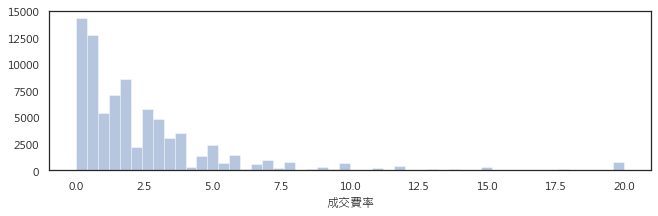

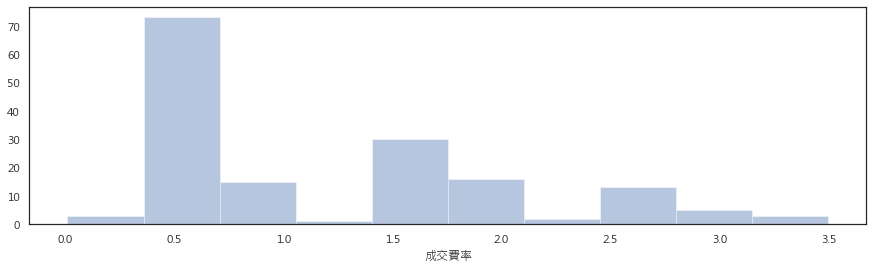

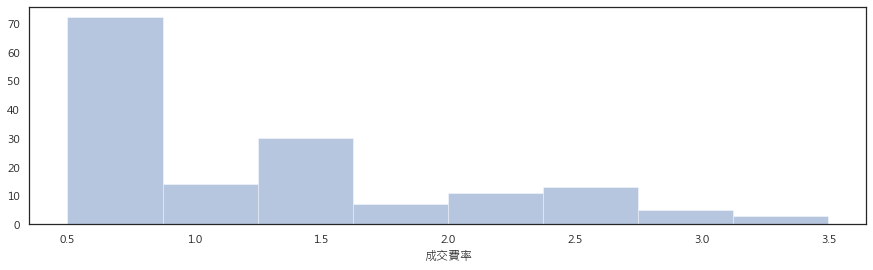

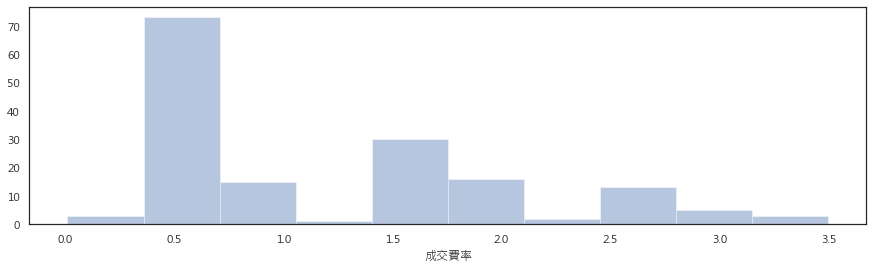

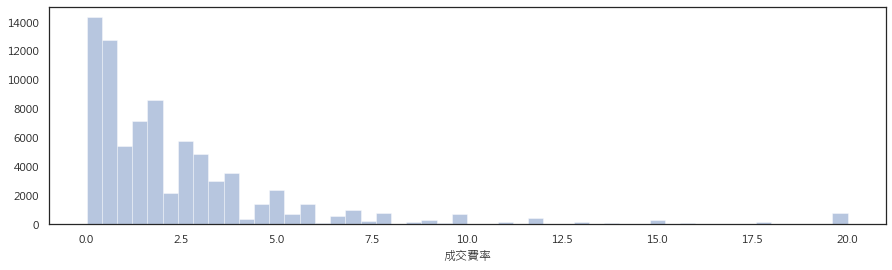

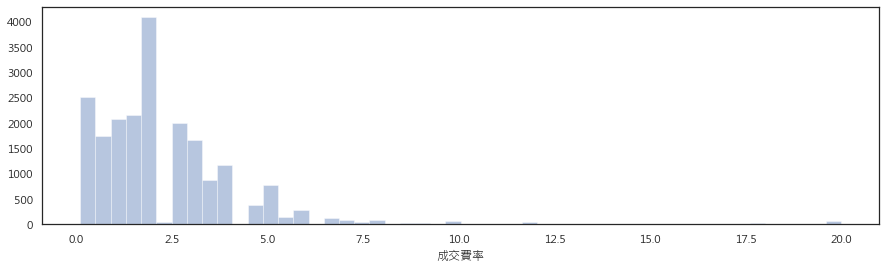

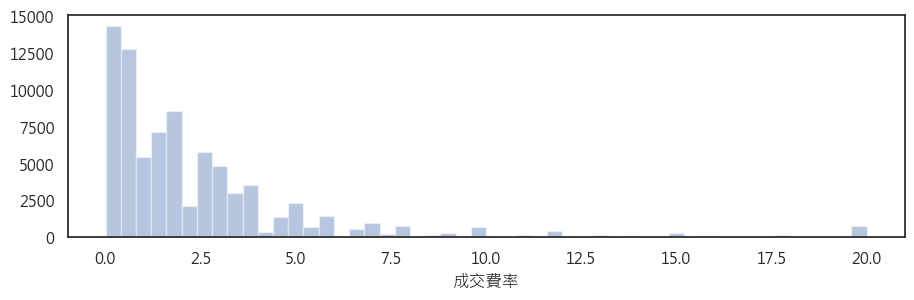

In [12]:
import pandas as pd
import numpy as np
from tkinter import *
from tkinter import ttk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import seaborn as sns
import matplotlib.pyplot as plt
from pandastable import Table, TableModel

#Create the frame class and call my functions from inside the class

class UserInterface(Table):
    # Launch the df in a pandastable frame

    def handleCellEntry(self, row, col):
        super().handleCellEntry(row, col)
        print('changed:', row, col, "(TODO: update database)")
        return    

    def change_df_combo(self, event):
        #Responds to combobox, filter by 'Sec_type'
        global ui_df, refresh_plot
        combo_selection = str(combo_box.get())
        combo_selection1 = str(combo_box1.get())
        combo_selection2 = str(combo_box2.get())
        
        ui_df = pos_df.copy()
        
        if combo_selection == "選擇成交日期":
            pass
        else:
            ui_df = ui_df[pos_df.成交日期.apply(lambda x:str(x)) == combo_selection]
            
        if combo_selection1 == "選擇交易方式":
            pass
        else:
            ui_df = ui_df.query("交易方式 == @combo_selection1")
            
        if combo_selection2 == "選擇證券代號":
            pass
        else:
            ui_df = ui_df.query("證券代號 == @combo_selection2") 
        
        refresh_plot(event)
            
        self.updateModel(TableModel(ui_df))
        self.redraw()
        
    def change_df_combo1(self, event):
        #Responds to combobox, filter by 'Sec_type'
        global ui_df, refresh_plot
        combo_selection = str(combo_box.get())
        combo_selection1 = str(combo_box1.get())
        combo_selection2 = str(combo_box2.get())
        
        ui_df = pos_df.copy()
        
        if combo_selection == "選擇成交日期":
            pass
        else:
            ui_df = ui_df[pos_df.成交日期.apply(lambda x:str(x)) == combo_selection]
            
        if combo_selection1 == "選擇交易方式":
            pass
        else:
            ui_df = ui_df.query("交易方式 == @combo_selection1")
            
        if combo_selection2 == "選擇證券代號":
            pass
        else:
            ui_df = ui_df.query("證券代號 == @combo_selection2") 
            
        refresh_plot(event)
            
        self.updateModel(TableModel(ui_df))
        self.redraw()
        
    def change_df_combo2(self, event):
        global ui_df, refresh_plot
        #Responds to combobox, filter by 'Sec_type'
        combo_selection = str(combo_box.get())
        combo_selection1 = str(combo_box1.get())
        combo_selection2 = str(combo_box2.get())
        
        ui_df = pos_df.copy()
        
        if combo_selection == "選擇成交日期":
            pass
        else:
            ui_df = ui_df[pos_df.成交日期.apply(lambda x:str(x)) == combo_selection]
            
        if combo_selection1 == "選擇交易方式":
            pass
        else:
            ui_df = ui_df.query("交易方式 == @combo_selection1")
            
        if combo_selection2 == "選擇證券代號":
            pass
        else:
            ui_df = ui_df.query("證券代號 == @combo_selection2") 
            
        refresh_plot(event)

        self.updateModel(TableModel(ui_df))
        self.redraw()

        
def create_plot():
    sns.set(style="white")
    plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(15, 4))

    sns.distplot(ui_df.成交費率, kde=False)
    
    return f

def create_plot_line():
    sns.set(style="white")
    plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(15, 4))

    sns.lineplot(y=ui_df.成交費率, x=list(range(len(ui_df.成交費率))))
    
    return f
    
def refresh_plot(event):
    global fig, canvas, ui_df
    
    combo_selection3 = str(combo_box3.get())
    
    if combo_selection3 == "分配圖":
        fig = create_plot()

    elif combo_selection3 =='折線圖':
        fig = create_plot_line()
    
    canvas.figure = fig
#     canvas = FigureCanvasTkAgg(fig, master=root)
    canvas.draw()
#     canvas.get_tk_widget().grid(column=0, row=3, sticky=(NW),padx=5)
    
pos_df = df
ui_df = pos_df

#Launch Tkinter basics
root = Tk()
root.title("借券費率")

mainframe = ttk.Frame(root, padding="3 3 3 3")
mainframe.grid(column=0, row=0, sticky=(N, W, E, S))
mainframe.columnconfigure(0, weight=1)
mainframe.rowconfigure(0, weight=1)
root.columnconfigure(0, weight=1)
root.rowconfigure(0, weight=1)

f = Frame(mainframe)
f.grid(column=0, row=2, sticky=(E, W))
screen_width = f.winfo_screenwidth() * 0.4
screen_height = f.winfo_screenheight() * 0.3

ui = UserInterface(f, dataframe=pos_df, height = screen_height, width = screen_width, showtoolbar=True, editable=False)


#Combobox to filter df
combo_choices = ['選擇成交日期']+list(np.unique(df.成交日期))
choice = StringVar()
combo_box = ttk.Combobox(mainframe, textvariable=choice)
combo_box['values'] = combo_choices
combo_box.grid(column=0, row=0, sticky=(NW))
combo_box.set("選擇成交日期")
combo_box.bind('<<ComboboxSelected>>', ui.change_df_combo)

#Combobox to filter df
combo_choices1 = ['選擇交易方式']+list(np.unique(df.交易方式))
choice1 = StringVar()
combo_box1 = ttk.Combobox(mainframe, textvariable=choice1, )
combo_box1['values'] = combo_choices1
combo_box1.grid(column=0, row=0)
combo_box1.set("選擇交易方式")
combo_box1.bind('<<ComboboxSelected>>', ui.change_df_combo1)

combo_choices2 = ['選擇證券代號']+list(np.unique(df.證券代號))
choice2 = StringVar()
combo_box2 = ttk.Combobox(mainframe, textvariable=choice2)
combo_box2['values'] = combo_choices2
combo_box2.grid(column=0, row=0, sticky=(NE))
combo_box2.set("選擇證券代號")
combo_box2.bind('<<ComboboxSelected>>', ui.change_df_combo2)

combo_choices3 = ['分配圖','折線圖']
choice3 = StringVar()
combo_box3 = ttk.Combobox(mainframe, textvariable=choice3)
combo_box3['values'] = combo_choices3
combo_box3.grid(column=0, row=3, sticky=(NE))
combo_box3.set("分配圖")
combo_box3.bind('<<ComboboxSelected>>', refresh_plot)

fig = create_plot()
canvas = FigureCanvasTkAgg(fig, master=root)
canvas.draw()
canvas.get_tk_widget().grid(column=0, row=3, sticky=(N))


ui.show()

root.mainloop()

In [10]:
UserInterface?

Init signature:
UserInterface(
    parent=None,
    model=None,
    dataframe=None,
    width=None,
    height=None,
    rows=20,
    cols=5,
    showtoolbar=False,
    showstatusbar=False,
    editable=True,
    enable_menus=True,
    **kwargs,
)
Docstring:     
A tkinter class for providing table functionality.

Args:
    parent: parent Frame
    model: a TableModel with some data
    dataframe: a pandas DataFrame
    width: width of frame
    height: height of frame
    rows: number of rows if creating empty table
    cols: number of columns if creating empty table
    showtoolbar: whether to show the toolbar, default False
    showstatusbar: whether to show the statusbar
Init docstring:
Construct a canvas widget with the parent MASTER.

Valid resource names: background, bd, bg, borderwidth, closeenough,
confine, cursor, height, highlightbackground, highlightcolor,
highlightthickness, insertbackground, insertborderwidth,
insertofftime, insertontime, insertwidth, offset, relief,
scro

In [52]:
ui_df

,成交日期,證券代號,證券名稱,交易方式,成交數量(交易單位),成交費率,成交日收盤價,約定還券日期,約定借券天數,費率異動
0,2020-10-05,0050,元大台灣50,競價,100,0.70,103.05,2021-04-01,178,
1,2020-10-05,00677U,富邦VIX,競價,150,2.80,4.77,2021-04-05,182,
2,2020-10-05,00752,中信中國50,競價,50,7.00,27.61,2021-04-05,182,
3,2020-10-05,1101,台泥,議借,2000,0.35,41.00,2021-04-05,182,
4,2020-10-05,1102,亞泥,議借,15,0.25,41.15,2021-04-05,182,
...,...,...,...,...,...,...,...,...,...,...
6561,2020-11-02,9938,百和,競價,24,0.50,68.80,2021-04-29,178,
6562,2020-11-02,9938,百和,議借,397,0.62,68.80,2021-04-29,178,
6563,2020-11-02,9939,宏全,議借,595,0.64,58.40,2021-04-29,178,
6564,2020-11-02,9945,潤泰新,議借,635,0.64,39.70,2021-04-29,178,


In [51]:
ui?

Type:            UserInterface
String form:     .!frame.!frame.!userinterface
Docstring:       <no docstring>
Class docstring:
A tkinter class for providing table functionality.

Args:
    parent: parent Frame
    model: a TableModel with some data
    dataframe: a pandas DataFrame
    width: width of frame
    height: height of frame
    rows: number of rows if creating empty table
    cols: number of columns if creating empty table
    showtoolbar: whether to show the toolbar, default False
    showstatusbar: whether to show the statusbar
Init docstring: 
Construct a canvas widget with the parent MASTER.

Valid resource names: background, bd, bg, borderwidth, closeenough,
confine, cursor, height, highlightbackground, highlightcolor,
highlightthickness, insertbackground, insertborderwidth,
insertofftime, insertontime, insertwidth, offset, relief,
scrollregion, selectbackground, selectborderwidth, selectforeground,
state, takefocus, width, xscrollcommand, xscrollincrement,
yscrollcomma

In [47]:
dir(ui)

['Xscrollbar',
 'Yscrollbar',
 '_Misc__winfo_getint',
 '_Misc__winfo_parseitem',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_bind',
 '_configure',
 '_create',
 '_displayof',
 '_do',
 '_eval',
 '_getFunction',
 '_getboolean',
 '_getconfigure',
 '_getconfigure1',
 '_getdoubles',
 '_getints',
 '_grid_configure',
 '_gridconvvalue',
 '_last_child_ids',
 '_name',
 '_nametowidget',
 '_noarg_',
 '_options',
 '_register',
 '_report_exception',
 '_root',
 '_setup',
 '_subst_format',
 '_subst_format_str',
 '_substitute',
 '_tclCommands',
 '_w',
 '_windowingsystem',
 'addColumn',
 'addRow',
 'addRows',
 'addtag',
 'addtag_above',
 'addtag_all'

In [41]:
dir(canvas)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_button',
 '_fix_ipython_backend2gui',
 '_get_key',
 '_get_output_canvas',
 '_idle',
 '_idle_callback',
 '_idle_draw_cntx',
 '_is_idle_drawing',
 '_is_saving',
 '_key',
 '_keycode_lookup',
 '_lastKey',
 '_lastx',
 '_lasty',
 '_master',
 '_resize_callback',
 '_tkcanvas',
 '_tkphoto',
 'blit',
 'buffer_rgba',
 'button_dblclick_event',
 'button_pick_id',
 'button_press_event',
 'button_release_event',
 'callbacks',
 'close_event',
 'copy_from_bbox',
 'draw',
 'draw_cursor',
 'draw_event',
 'draw_idle',
 'enter_notify_event',
 'events',
 'figure',
 'filetypes',
 'fixed_dpi',
 'flush_events',
 'get_default_filename',
 'get_de

In [ ]:
dir(canvas.get_tk_widget())

In [3]:
import tkinter as tk
from pandas import DataFrame
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

data1 = {'Country': ['US','CA','GER','UK','FR'],
         'GDP_Per_Capita': [45000,42000,52000,49000,47000]
        }
df1 = DataFrame(data1,columns=['Country','GDP_Per_Capita'])


data2 = {'Year': [1920,1930,1940,1950,1960,1970,1980,1990,2000,2010],
         'Unemployment_Rate': [9.8,12,8,7.2,6.9,7,6.5,6.2,5.5,6.3]
        }
df2 = DataFrame(data2,columns=['Year','Unemployment_Rate'])


data3 = {'Interest_Rate': [5,5.5,6,5.5,5.25,6.5,7,8,7.5,8.5],
         'Stock_Index_Price': [1500,1520,1525,1523,1515,1540,1545,1560,1555,1565]
        }  
df3 = DataFrame(data3,columns=['Interest_Rate','Stock_Index_Price'])
 

root= tk.Tk() 
  
figure1 = plt.Figure(figsize=(6,5), dpi=100)
ax1 = figure1.add_subplot(111)
bar1 = FigureCanvasTkAgg(figure1, root)
bar1.get_tk_widget().pack(side=tk.LEFT, fill=tk.BOTH)
df1 = df1[['Country','GDP_Per_Capita']].groupby('Country').sum()
df1.plot(kind='bar', legend=True, ax=ax1)
ax1.set_title('Country Vs. GDP Per Capita')

figure2 = plt.Figure(figsize=(5,4), dpi=100)
ax2 = figure2.add_subplot(111)
line2 = FigureCanvasTkAgg(figure2, root)
line2.get_tk_widget().pack(side=tk.LEFT, fill=tk.BOTH)
df2 = df2[['Year','Unemployment_Rate']].groupby('Year').sum()
df2.plot(kind='line', legend=True, ax=ax2, color='r',marker='o', fontsize=10)
ax2.set_title('Year Vs. Unemployment Rate')

figure3 = plt.Figure(figsize=(5,4), dpi=100)
ax3 = figure3.add_subplot(111)
ax3.scatter(df3['Interest_Rate'],df3['Stock_Index_Price'], color = 'g')
scatter3 = FigureCanvasTkAgg(figure3, root) 
scatter3.get_tk_widget().pack(side=tk.LEFT, fill=tk.BOTH)
ax3.legend(['Stock_Index_Price']) 
ax3.set_xlabel('Interest Rate')
ax3.set_title('Interest Rate Vs. Stock Index Price')

root.mainloop()

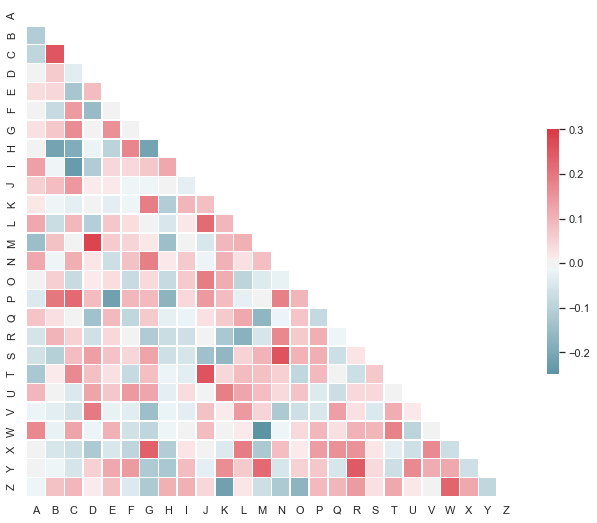

In [6]:
# seaborn in matplotlib - tkinter doesn't need it
#import matplotlib
#matplotlib.use('TkAgg')

# embed matplotlib in tkinter 
import tkinter
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

# seaborn example
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def create_plot():
    sns.set(style="white")

    # Generate a large random dataset
    rs = np.random.RandomState(33)
    d = pd.DataFrame(data=rs.normal(size=(100, 26)),
                     columns=list(ascii_letters[26:]))

    # Compute the correlation matrix
    corr = d.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

    return f

# --- main ---

root = tkinter.Tk()
root.wm_title("Embedding in Tk")

label = tkinter.Label(root, text="Matplotlib with Seaborn in Tkinter")
label.pack()

fig = create_plot()

canvas = FigureCanvasTkAgg(fig, master=root)  # A tk.DrawingArea.
canvas.draw()
canvas.get_tk_widget().pack()

button = tkinter.Button(root, text="Quit", command=root.destroy)
button.pack()

tkinter.mainloop()

In [18]:
today_month =  datetime.date.today().month
last_month = today_month -1
today_day = datetime.date.today().day

#如果是個位數需要補0，否則不能丟到post裡面
if len(str(today_month))<2:
    today_month = "0"+str(today_month)

if len(str(last_month))<2:
    last_month = "0"+str(last_month)
    
if len(str(today_day))<2:
    today_day = "0"+str(today_day)

today_month_day = str(today_month) + str(today_day)

In [19]:
res = requests.get('https://www.twse.com.tw/SBL/t13sa710?response=csv&startDate=2020{}01&endDate=2020{}&stockNo=&tradeType='.format(last_month, today_month_day))

In [20]:
a = res.text.split('\r\n')[1:-6] #原始文字清洗，清除首行及表尾說明語句
b = [a.replace('=', "") for a in a]  #非個股其證券代號名稱前會有等號，予以刪除
c = [c.split('","') for c in b] #每一列分割欄位

In [21]:
df = pd.DataFrame(c[1:], columns=c[0])

In [22]:
df.columns = [col.replace('"', "").replace(",","") for col in df.columns]
df = df.applymap(lambda x:str(x).replace('"', "").replace(",", ""))

In [23]:
df

,成交日期,證券代號名稱,交易方式,成交數量(交易單位),成交費率,成交日收盤價,約定還券日期,約定借券天數,費率異動
0,109年10月05日,0050 元大台灣50,競價,100,0.70,103.05,110年04月01日,178,
1,109年10月05日,00677U 富邦VIX,競價,150,2.80,4.77,110年04月05日,182,
2,109年10月05日,00752 中信中國50,競價,50,7.00,27.61,110年04月05日,182,
3,109年10月05日,1101 台泥,議借,2000,0.35,41.00,110年04月05日,182,
4,109年10月05日,1102 亞泥,議借,15,0.25,41.15,110年04月05日,182,
...,...,...,...,...,...,...,...,...,...
6561,109年11月02日,9938 百和,競價,24,0.50,68.80,110年04月29日,178,
6562,109年11月02日,9938 百和,議借,397,0.62,68.80,110年04月29日,178,
6563,109年11月02日,9939 宏全,議借,595,0.64,58.40,110年04月29日,178,
6564,109年11月02日,9945 潤泰新,議借,635,0.64,39.70,110年04月29日,178,


# 清理名稱欄位

In [24]:
patterns = re.compile(u"[\u4e00-\u9fa5-A-z0-9]+")

In [25]:
pattern = r"^[0-9A-z]*"
df['證券代號'] = df.證券代號名稱.apply(lambda x:re.findall(patterns,x)[0])
df['證券名稱'] = df.證券代號名稱.apply(lambda x:re.findall(patterns,x)[1])

In [26]:
df['成交日期'] = df.成交日期.apply(lambda x:int(re.sub(r'年|月|日', '', x))+19110000)
df['成交日期'] = pd.to_datetime(df['成交日期'], format='%Y%m%d')
df['成交日期'] = df['成交日期'].apply(lambda x:x.date())
df['約定還券日期'] = df.約定還券日期.apply(lambda x:int(re.sub(r'年|月|日', '', x))+19110000)
df['約定還券日期'] = pd.to_datetime(df['約定還券日期'], format='%Y%m%d')
df['約定還券日期'] = df['約定還券日期'].apply(lambda x:x.date())

In [27]:
df = df[['成交日期',
        '證券代號', 
        '證券名稱', 
        '交易方式', 
        '成交數量(交易單位)', 
        '成交費率', 
        '成交日收盤價', 
        '約定還券日期',
        '約定借券天數', 
        '費率異動'
       ]]

In [28]:
# !pip install pandastable --trusted-host pypi.python.org --trusted-host files.pythonhosted.org --trusted-host pypi.org

In [29]:
# from tkinter import *
# from pandastable import Table, TableModel

# class TestApp(Frame):
#         """Basic test frame for the table"""
#         def __init__(self, parent=None):
#             self.parent = parent
#             Frame.__init__(self)
#             self.main = self.master
#             self.main.geometry('1200x800+200+100')
#             self.main.title('借券費率')
#             f = Frame(self.main)
#             f.pack(fill=BOTH,expand=1)
# #             df = TableModel.getSampleData()
#             self.table = pt = Table(f, dataframe=df,
#                                     showtoolbar=0, showstatusbar=False)
#             pt.show()
#             return

# app = TestApp()
# #launch the app
# app.mainloop()

In [30]:
import pandas as pd
import numpy as np
from tkinter import *
from tkinter import ttk
from pandastable import Table, TableModel

#Create the frame class and call my functions from inside the class

class UserInterface(Table):
    # Launch the df in a pandastable frame

    def handleCellEntry(self, row, col):
        super().handleCellEntry(row, col)
        print('changed:', row, col, "(TODO: update database)")
        return    

    def change_df_combo(self, event):
        #Responds to combobox, filter by 'Sec_type'
        combo_selection = str(combo_box.get())
        combo_selection1 = str(combo_box1.get())
        combo_selection2 = str(combo_box2.get())
        
        ui_df = pos_df.copy()
        
        if combo_selection == "選擇成交日期":
            pass
        else:
            ui_df = ui_df[pos_df.成交日期.apply(lambda x:str(x)) == combo_selection]
            
        if combo_selection1 == "選擇交易方式":
            pass
        else:
            ui_df = ui_df.query("交易方式 == @combo_selection1")
            
        if combo_selection2 == "選擇證券代號":
            pass
        else:
            ui_df = ui_df.query("證券代號 == @combo_selection2") 
            
        self.updateModel(TableModel(ui_df))
        self.redraw()
        
    def change_df_combo1(self, event):
        #Responds to combobox, filter by 'Sec_type'
        combo_selection = str(combo_box.get())
        combo_selection1 = str(combo_box1.get())
        combo_selection2 = str(combo_box2.get())
        
        ui_df = pos_df.copy()
        
        if combo_selection == "選擇成交日期":
            pass
        else:
            ui_df = ui_df[pos_df.成交日期.apply(lambda x:str(x)) == combo_selection]
            
        if combo_selection1 == "選擇交易方式":
            pass
        else:
            ui_df = ui_df.query("交易方式 == @combo_selection1")
            
        if combo_selection2 == "選擇證券代號":
            pass
        else:
            ui_df = ui_df.query("證券代號 == @combo_selection2") 
            
        self.updateModel(TableModel(ui_df))
        self.redraw()
        
    def change_df_combo2(self, event):
        #Responds to combobox, filter by 'Sec_type'
        combo_selection = str(combo_box.get())
        combo_selection1 = str(combo_box1.get())
        combo_selection2 = str(combo_box2.get())
        
        ui_df = pos_df.copy()
        
        if combo_selection == "選擇成交日期":
            pass
        else:
            ui_df = ui_df[pos_df.成交日期.apply(lambda x:str(x)) == combo_selection]
            
        if combo_selection1 == "選擇交易方式":
            pass
        else:
            ui_df = ui_df.query("交易方式 == @combo_selection1")
            
        if combo_selection2 == "選擇證券代號":
            pass
        else:
            ui_df = ui_df.query("證券代號 == @combo_selection2") 

        self.updateModel(TableModel(ui_df))
        self.redraw()

pos_df = df
ui_df = pos_df

#Launch Tkinter basics
root = Tk()
root.title("借券費率")

mainframe = ttk.Frame(root, padding="3 3 8 8")
mainframe.grid(column=0, row=0, sticky=(N, W, E, S))
mainframe.columnconfigure(0, weight=1)
mainframe.rowconfigure(0, weight=1)
# root.columnconfigure(0, weight=1)
# root.rowconfigure(0, weight=1)

f = Frame(mainframe)
f.grid(column=0, row=5, sticky=(E, W))
screen_width = f.winfo_screenwidth() * 0.6
screen_height = f.winfo_screenheight() * 0.6

ui = UserInterface(f, dataframe=pos_df, height = screen_height, width = screen_width, showtoolbar=True)

#'Test' button, adds a column
# col_val_input = 'It worked!'
# test_button = ttk.Button(mainframe, text = 'Test', command= lambda: ui.change_df(input_val=col_val_input))
# test_button.grid(column=0, row=0, sticky=(W))

#Combobox to filter df
combo_choices = ['選擇成交日期']+list(np.unique(df.成交日期))
choice = StringVar()
combo_box = ttk.Combobox(mainframe, textvariable=choice)
combo_box['values'] = combo_choices
combo_box.grid(column=0, row=0, sticky=(NW))
combo_box.set("選擇成交日期")
combo_box.bind('<<ComboboxSelected>>', ui.change_df_combo)

#Combobox to filter df
combo_choices1 = ['選擇交易方式']+list(np.unique(df.交易方式))
choice1 = StringVar()
combo_box1 = ttk.Combobox(mainframe, textvariable=choice1, )
combo_box1['values'] = combo_choices1
combo_box1.grid(column=0, row=0)
combo_box1.set("選擇交易方式")
combo_box1.bind('<<ComboboxSelected>>', ui.change_df_combo1)

combo_choices2 = ['選擇證券代號']+list(np.unique(df.證券代號))
choice2 = StringVar()
combo_box2 = ttk.Combobox(mainframe, textvariable=choice2)
combo_box2['values'] = combo_choices2
combo_box2.grid(column=0, row=0, sticky=(NE))
combo_box2.set("選擇證券代號")
combo_box2.bind('<<ComboboxSelected>>', ui.change_df_combo2)

ui.show()

root.mainloop()

In [122]:
ttk.Combobox?

Init signature: ttk.Combobox(master=None, **kw)
Docstring:     
Ttk Combobox widget combines a text field with a pop-down list of
values.
Init docstring:
Construct a Ttk Combobox widget with the parent master.

STANDARD OPTIONS

    class, cursor, style, takefocus

WIDGET-SPECIFIC OPTIONS

    exportselection, justify, height, postcommand, state,
    textvariable, values, width
File:           c:\users\user12\anaconda3\lib\tkinter\ttk.py
Type:           type
Subclasses:     


In [107]:
ui_df

,成交日期,證券代號,證券名稱,交易方式,成交數量(交易單位),成交費率,成交日收盤價,約定還券日期,約定借券天數,費率異動
0,2020-09-01,0050,元大台灣50,議借,459,0.20,103.35,110年03月01日,181,
1,2020-09-01,00632R,元大台灣50反1,議借,21103,0.20,8.36,110年03月01日,181,
2,2020-09-01,00636,國泰中國A50,議借,2365,0.20,24.59,110年03月01日,181,
3,2020-09-01,1101,台泥,議借,744,0.20,42.75,110年03月01日,181,
4,2020-09-01,1101,台泥,議借,8200,0.44,42.75,110年03月01日,181,
...,...,...,...,...,...,...,...,...,...,...
14676,2020-10-29,8436,大江,議借,200,2.50,227.00,110年04月29日,182,
14677,2020-10-29,912398,友佳-DR,競價,20,3.00,5.65,110年04月29日,182,
14678,2020-10-29,9904,寶成,議借,2175,0.64,25.70,110年04月29日,182,
14679,2020-10-29,9910,豐泰,議借,180,1.00,173.50,110年04月29日,182,


In [104]:
ttk.Combobox(mainframe, textvariable=choice2)

TclError: NULL main window

In [100]:
df[df.證券代號.apply(lambda x:str(x)) == combo_selection]

,成交日期,證券代號,證券名稱,交易方式,成交數量(交易單位),成交費率,成交日收盤價,約定還券日期,約定借券天數,費率異動
0,2020-09-01,0050,元大台灣50,議借,459,0.20,103.35,110年03月01日,181,
1404,2020-09-04,0050,元大台灣50,競價,300,0.70,102.55,110年03月04日,181,
2476,2020-09-09,0050,元大台灣50,競價,110,0.70,102.30,110年03月09日,181,
2477,2020-09-09,0050,元大台灣50,競價,43,0.70,102.30,110年03月09日,181,
2478,2020-09-09,0050,元大台灣50,競價,319,0.70,102.30,110年03月09日,181,
2479,2020-09-09,0050,元大台灣50,競價,359,0.70,102.30,110年03月09日,181,
3700,2020-09-11,0050,元大台灣50,競價,150,0.70,103.25,110年03月11日,181,
3701,2020-09-11,0050,元大台灣50,競價,500,0.70,103.25,110年03月10日,180,
4656,2020-09-16,0050,元大台灣50,議借,3400,0.20,106.55,110年03月16日,181,
5377,2020-09-18,0050,元大台灣50,競價,40,0.70,105.30,110年03月18日,181,


In [59]:
list(np.unique(df.交易方式))

['競價', '議借']

In [92]:
df

,成交日期,證券代號,證券名稱,交易方式,成交數量(交易單位),成交費率,成交日收盤價,約定還券日期,約定借券天數,費率異動
0,2020-09-01,0050,元大台灣50,議借,459,0.20,103.35,110年03月01日,181,
1,2020-09-01,00632R,元大台灣50反1,議借,21103,0.20,8.36,110年03月01日,181,
2,2020-09-01,00636,國泰中國A50,議借,2365,0.20,24.59,110年03月01日,181,
3,2020-09-01,1101,台泥,議借,744,0.20,42.75,110年03月01日,181,
4,2020-09-01,1101,台泥,議借,8200,0.44,42.75,110年03月01日,181,
...,...,...,...,...,...,...,...,...,...,...
14676,2020-10-29,8436,大江,議借,200,2.50,227.00,110年04月29日,182,
14677,2020-10-29,912398,友佳-DR,競價,20,3.00,5.65,110年04月29日,182,
14678,2020-10-29,9904,寶成,議借,2175,0.64,25.70,110年04月29日,182,
14679,2020-10-29,9910,豐泰,議借,180,1.00,173.50,110年04月29日,182,


In [127]:
from tkinter import *
from pandastable import Table, TableModel

class MyTable(Table):
    """Custom table class inherits from Table. You can then override required methods"""
    def __init__(self, parent=None, **kwargs):
        Table.__init__(self, parent, **kwargs)
        return
    
    def handle_left_click(self, event):
        """Example - override left click"""

        Table.handle_left_click(self, event)
  #do custom code here
        return

    def popupMenu(self, event, rows=None, cols=None, outside=None):
        """Custom right click menu"""

        popupmenu = Menu(self, tearoff = 0)
        def popupFocusOut(event):
            popupmenu.unpost()
                                # add commands here
    # self.app is a reference to the parent app
        popupmenu.add_command(label='do stuff', command=self.app.stuff)
        popupmenu.bind("<FocusOut>", popupFocusOut)
        popupmenu.focus_set()
        popupmenu.post(event.x_root, event.y_root)
        return popupmenu

app = TestApp()
#launch the app
app.mainloop()

Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\user12\anaconda3\lib\tkinter\__init__.py", line 1883, in __call__
    return self.func(*args)
  File "C:\Users\user12\anaconda3\lib\site-packages\pandastable\core.py", line 1737, in statsViewer
    self.sv = StatsViewer(table=self,parent=sf)
  File "C:\Users\user12\anaconda3\lib\site-packages\pandastable\stats.py", line 64, in __init__
    self.setupGUI()
  File "C:\Users\user12\anaconda3\lib\site-packages\pandastable\stats.py", line 72, in setupGUI
    formula = self.guessFormula()
  File "C:\Users\user12\anaconda3\lib\site-packages\pandastable\stats.py", line 122, in guessFormula
    df = df.convert_objects(convert_numeric='force')
  File "C:\Users\user12\anaconda3\lib\site-packages\pandas\core\generic.py", line 5274, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'convert_objects'


In [58]:
df

,成交日期,證券代號,證券名稱,交易方式,成交數量(交易單位),成交費率,成交日收盤價,約定還券日期,約定借券天數,費率異動
0,2020-09-01,0050,元大台灣50,議借,459,0.20,103.35,2021-03-01,181,
1,2020-09-01,00632R,元大台灣50反1,議借,21103,0.20,8.36,2021-03-01,181,
2,2020-09-01,00636,國泰中國A50,議借,2365,0.20,24.59,2021-03-01,181,
3,2020-09-01,1101,台泥,議借,744,0.20,42.75,2021-03-01,181,
4,2020-09-01,1101,台泥,議借,8200,0.44,42.75,2021-03-01,181,
...,...,...,...,...,...,...,...,...,...,...
14676,2020-10-29,8436,大江,議借,200,2.50,227.00,2021-04-29,182,
14677,2020-10-29,912398,友佳-DR,競價,20,3.00,5.65,2021-04-29,182,
14678,2020-10-29,9904,寶成,議借,2175,0.64,25.70,2021-04-29,182,
14679,2020-10-29,9910,豐泰,議借,180,1.00,173.50,2021-04-29,182,


In [104]:
import pandas as pd
import numpy as np
from tkinter import *
from tkinter import ttk
from pandastable import Table, TableModel

#Create the frame class and call my functions from inside the class

class UserInterface(Table):
    # Launch the df in a pandastable frame

    def handleCellEntry(self, row, col):
        super().handleCellEntry(row, col)
        print('changed:', row, col, "(TODO: update database)")
        return    

    def change_df_combo(self, event):
        #Responds to combobox, filter by 'Sec_type'
        combo_selection = str(combo_box.get())
        ui_df = pos_df[pos_df['Sec_type'] == combo_selection]
        ui_df['Test col combo'] = combo_selection
        self.updateModel(TableModel(ui_df))
        self.redraw()

pos_df = df

ui_df = df

#Launch Tkinter basics
root = Tk()
root.title("借券費率")

mainframe = ttk.Frame(root, padding="3 3 8 8")
mainframe.grid(column=0, row=0, sticky=(N, W, E, S))
mainframe.columnconfigure(0, weight=1)
mainframe.rowconfigure(0, weight=1)
root.columnconfigure(0, weight=1)
root.rowconfigure(0, weight=1)

f = Frame(mainframe)
f.grid(column=0, row=1, sticky=(E, W))
screen_width = f.winfo_screenwidth() * 0.6
screen_height = f.winfo_screenheight() * 0.6

ui = UserInterface(f, dataframe=pos_df, height = screen_height, width = screen_width)

#'Test' button, adds a column
# col_val_input = 'It worked!'
# test_button = ttk.Button(mainframe, text = 'Test', command= lambda: ui.change_df(input_val=col_val_input))
# test_button.grid(column=0, row=0, sticky=(W))

#Combobox to filter df
combo_choices = ['mbus', 'vmus', 'caus']
choice = StringVar()
combo_box = ttk.Combobox(mainframe, textvariable=choice)
combo_box['values'] = combo_choices
combo_box.grid(column=1, row=0, sticky=(W))
combo_box.bind('<<ComboboxSelected>>', ui.change_df_combo)

ui.show()

root.mainloop()

TclError: invalid command name ".!canvas"

In [35]:
import pandas as pd
import numpy as np
from tkinter import *
from tkinter import ttk
from pandastable import Table, TableModel

#Create the frame class and call my functions from inside the class

class UserInterface(Table):
    # Launch the df in a pandastable frame

    def handleCellEntry(self, row, col):
        super().handleCellEntry(row, col)
        print('changed:', row, col, "(TODO: update database)")
        return    

    def change_df(self, input_val):
        #Responds to button
        ui_df['Test col'] = input_val
        self.updateModel(TableModel(ui_df))
        self.redraw()

    def change_df_combo(self, event):
        #Responds to combobox, filter by 'Sec_type'
        combo_selection = str(combo_box.get())
        ui_df = pos_df[pos_df['Sec_type'] == combo_selection]
        ui_df['Test col combo'] = combo_selection
        self.updateModel(TableModel(ui_df))
        self.redraw()

pos_data = {'Location' : ['Denver', 'Boulder', 'Phoenix', 'Reno', 'Portland',
    'Eugene', 'San Francisco'], 'Sec_type' : ['mbus', 'mbus', 'vmus', 'caus',
    'vmus', 'mbus', 'mbus'], 'Rando_num': [18, 5, 34, 11, 72, 42, 9]}
pos_df = pd.DataFrame(data = pos_data)

ui_df = pos_df

#Launch Tkinter basics
root = Tk()
root.title("S test...")

mainframe = ttk.Frame(root, padding="3 3 12 12")
mainframe.grid(column=0, row=0, sticky=(N, W, E, S))
mainframe.columnconfigure(0, weight=1)
mainframe.rowconfigure(0, weight=1)
root.columnconfigure(0, weight=1)
root.rowconfigure(0, weight=1)

f = Frame(mainframe)
f.grid(column=0, row=1, sticky=(E, W))
screen_width = f.winfo_screenwidth() * 0.8
screen_height = f.winfo_screenheight() * 0.7

ui = UserInterface(f, dataframe=pos_df, height = screen_height, width = screen_width)

#'Test' button, adds a column
col_val_input = 'It worked!'
test_button = ttk.Button(mainframe, text = 'Test', command= lambda: ui.change_df(input_val=col_val_input))
test_button.grid(column=0, row=0, sticky=(W))

#Combobox to filter df
combo_choices = ['mbus', 'vmus', 'caus']
choice = StringVar()
combo_box = ttk.Combobox(mainframe, textvariable=choice)
combo_box['values'] = combo_choices
combo_box.grid(column=1, row=0, sticky=(W))
combo_box.bind('<<ComboboxSelected>>', ui.change_df_combo)

ui.show()

root.mainloop()

<ipython-input-35-09efd779a8a4>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ui_df['Test col combo'] = combo_selection
